In [1]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

/Users/tonantzinrealrojas/miniforge3/envs/nlp/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploration Overview
In this notebook, we have five objectives: 
1. Clean the data and determine the number of unique users
2. Find the percentage of missing values for each feature
3. Examine the distribution of the target variable
4. Compute the summary statistics for numerical features
5. Examine the distribution of the variables for each class of the target variable

In [2]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)


# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

## General Summary
- This dataset has 30000 unique users; however, after filtering out the invalid values for the `MARRIAGE` and `EDUCATION` variables, there are 29932 users. 
- The percentage of missing values for each feature is 0%. 
- Our target variable is `DEFAULT_STATUS`, which takes the value 1 when the user has defaulted and 0 otherwise. 
- The features that we are interested in are `ID`, `CREDIT_LINE`, `SEX`, `EDUCATION`, `MARRIAGE`, and `AGE`.
- Approximately 77.8% of the users in the dataset did not default (`DEFAULT_STATUS = 0`).

In [3]:
data_ = load_data(download_data())
print(data_.shape)
data_.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df_clean = data_[
    [
        "ID",
        "LIMIT_BAL",
        "SEX",
        "EDUCATION",
        "MARRIAGE",
        "AGE",
        "default.payment.next.month",
    ]
].copy()
df = df_clean.rename(columns={"default.payment.next.month": "DEFAULT_STATUS"})
df = df.rename(columns={"LIMIT_BAL": "CREDIT_LINE"})

df["MARRIAGE"] = df["MARRIAGE"].astype(
    int
)  # Convert MARRIAGE to integer type so that we can filter out invalid entries
df["EDUCATION"] = df["EDUCATION"].astype(
    int
)  # Convert EDUCATION to integer type so that we can filter out invalid entries

df = df[df["MARRIAGE"] != 0]  # Remove invalid marriage entries
df = df[df["EDUCATION"] != 0]  # Remove invalid education entries

print(df.shape)
df.head()

(29932, 7)


,ID,CREDIT_LINE,SEX,EDUCATION,MARRIAGE,AGE,DEFAULT_STATUS
0,1,20000.0,2,2,1,24,1
1,2,120000.0,2,2,2,26,1
2,3,90000.0,2,2,2,34,0
3,4,50000.0,2,2,1,37,0
4,5,50000.0,1,2,1,57,0


In [5]:
target = "DEFAULT_STATUS"
feats = ["ID", "CREDIT_LINE", "SEX", "EDUCATION", "MARRIAGE", "AGE"]

In [6]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Dictionary to store outlier info
outliers_info = {}

print("Outliers detected by IQR method:")
for col in numeric_cols:
    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = {"IQR_count": outliers_iqr.shape[0]}
    print(f"{col}: {outliers_iqr.shape[0]} outliers")

print("\nOutliers detected by Z-score method (threshold=3):")
for col in numeric_cols:
    # Drop NaNs first
    col_data = df[col].dropna()
    z_scores = np.abs(stats.zscore(col_data))
    # Select outliers keeping the index aligned
    outliers_z = col_data[z_scores > 3]
    outliers_info[col]["Z_score_count"] = outliers_z.shape[0]
    print(f"{col}: {outliers_z.shape[0]} outliers")

# Optional: combine the results into a DataFrame
outliers_df = pd.DataFrame(outliers_info).T
print("\nSummary of outliers by column:")
print(outliers_df)

Outliers detected by IQR method:
ID: 0 outliers
CREDIT_LINE: 167 outliers
SEX: 0 outliers
EDUCATION: 454 outliers
MARRIAGE: 0 outliers
AGE: 272 outliers
DEFAULT_STATUS: 6631 outliers

Outliers detected by Z-score method (threshold=3):
ID: 0 outliers
CREDIT_LINE: 130 outliers
SEX: 0 outliers
EDUCATION: 331 outliers
MARRIAGE: 0 outliers
AGE: 141 outliers
DEFAULT_STATUS: 0 outliers

Summary of outliers by column:
                IQR_count  Z_score_count
ID                      0              0
CREDIT_LINE           167            130
SEX                     0              0
EDUCATION             454            331
MARRIAGE                0              0
AGE                   272            141
DEFAULT_STATUS       6631              0


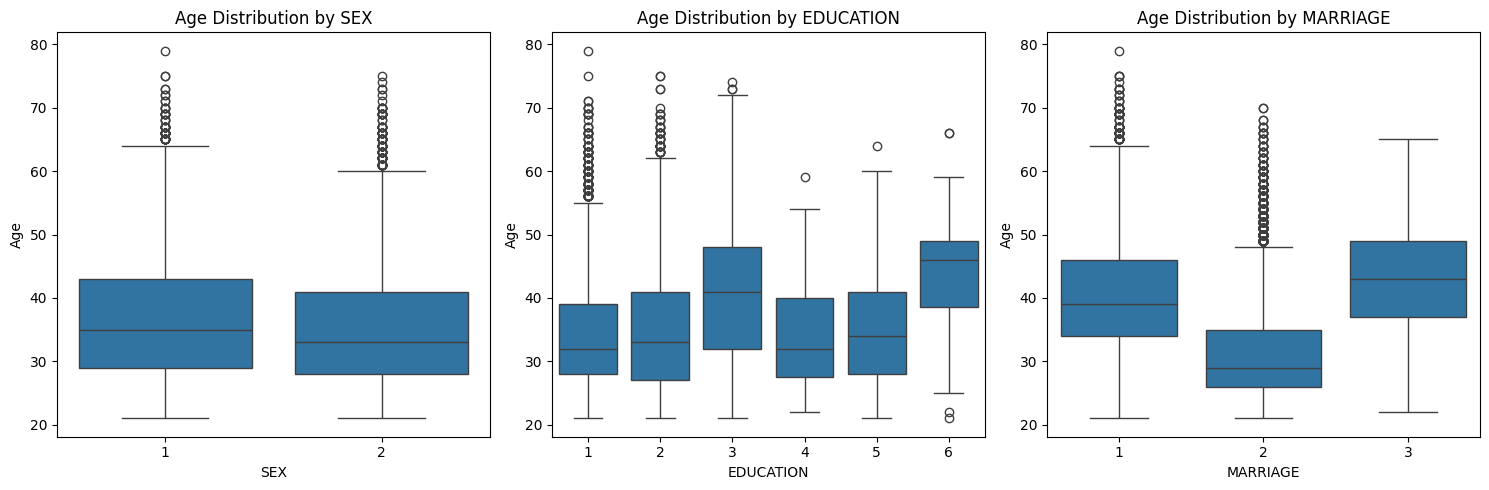

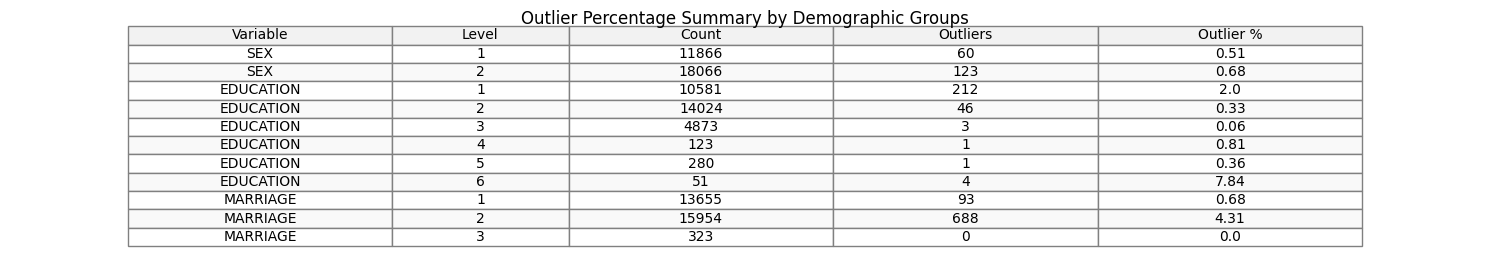

In [7]:
categorical_vars = ["SEX", "EDUCATION", "MARRIAGE"]
numeric_var = "AGE"


def outlier_table(df, group_col, value_col):
    rows = []
    for level, g in df.groupby(group_col):
        q1 = g[value_col].quantile(0.25)
        q3 = g[value_col].quantile(0.75)
        iqr = q3 - q1
        lo = q1 - 1.5 * iqr
        hi = q3 + 1.5 * iqr
        is_out = (g[value_col] < lo) | (g[value_col] > hi)
        rows.append(
            [group_col, level, len(g), int(is_out.sum()), round(100 * is_out.mean(), 2)]
        )
    return pd.DataFrame(
        rows, columns=["Variable", "Level", "Count", "Outliers", "Outlier %"]
    )


summary_df = pd.concat(
    [outlier_table(df, c, numeric_var) for c in categorical_vars], ignore_index=True
)

# Create figure for boxplots
plt.figure(figsize=(15, 5))

for i, cat in enumerate(categorical_vars, 1):
    plt.subplot(1, len(categorical_vars), i)
    sns.boxplot(x=cat, y=numeric_var, data=df)
    plt.title(f"Age Distribution by {cat}")
    plt.xlabel(cat)
    plt.ylabel("Age")

plt.tight_layout()
plt.show()

# Create figure for table with improved formatting
fig, ax = plt.subplots(figsize=(15, 3))
ax.axis("off")

# Create the table with improved formatting
tbl = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc="center",
    cellLoc="center",
    colColours=["#f2f2f2"] * len(summary_df.columns),  # Light gray header background
    colWidths=[0.15, 0.1, 0.15, 0.15, 0.15],  # Adjust column widths
)

# Improve table aesthetics
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.8)  # Make cells bigger

# Style the cells
for (row, col), cell in tbl.get_celld().items():
    cell.set_text_props(ha="center", va="center")
    cell.set_edgecolor("gray")  # Add cell borders

    if row == 0:  # Header row
        cell.set_text_props
        cell.set_facecolor("#f2f2f2")  # Light gray background for headers
    else:
        cell.set_facecolor("white")
        # Add alternating row colors for better readability
        if row % 2 == 0:
            cell.set_facecolor("#f9f9f9")  # Very light gray for even rows

# Add a title with more space
plt.title(
    "Outlier Percentage Summary by Demographic Groups",
    pad=30,
    fontsize=12,
)
plt.tight_layout()
plt.show()

From these boxplots, we can interpret the following: 
- Age distribution by sex: Both male and female groups have similar medians (~35 years), and there are few people aged above 65-70. 
- Age distribution by education: Each education range shows a simialr central range (~25-45), but there are some outliers above 60-70 years old. 
- Age distribution by marriage: There is a lower median for single people compared to the other groups. 

From outlier percentage table, we can interpret the following:
- Outliers by sex: Both male and female groups have under 1% outliers, showing age is consistent across genders.
- Outliers by education: Graduate-level individuals (EDUCATION = 1) show the highest age outliers (~2%), indicating slightly greater age variation in this group.
- Outliers by marriage status: Married individuals (MARRIAGE = 2) have the highest outlier rate (~4.31%), indicating greater age variability compared to other groups.

In [8]:
# 1. Determine the number of unique users
df.ID.nunique()

29932

In [9]:
# 2. Find the percentage of missing values for each feature
df.isnull().sum()

ID                0
CREDIT_LINE       0
SEX               0
EDUCATION         0
MARRIAGE          0
AGE               0
DEFAULT_STATUS    0
dtype: int64

In [10]:
# 3. Examine the distribution of the target variable
df[target].value_counts(normalize=True)

DEFAULT_STATUS
0    0.778465
1    0.221535
Name: proportion, dtype: float64

In [11]:
# 4. Compute the summary statistics for numerical features `credit_line` and `age`
df.groupby(target).agg({"CREDIT_LINE": ["mean", "median", "std", "min", "max"]})

df.groupby(target).agg({"AGE": ["mean", "median", "std", "min", "max"]})

AGE                         
                     mean median       std min max
DEFAULT_STATUS                                    
0               35.409768   34.0  9.078124  21  79
1               35.725532   34.0  9.694710  21  75

When comparing defaulters (`default_status = 1`) and non-defaulters (`default_status = 0`), we often see a higher standard deviation in both `CREDIT_LINE` and `AGE` among those who default. This indicates that defaulters may come from a wider range of credit limits and age groups. Some have very low credit lines, others quite high, suggesting that defaults occur across different financial profiles rather than within a narrow range.

If the mean or median credit line is higher for non-defaulters, it may suggest that individuals with larger and more stable credit limits tend to manage credit better. Conversely, a lower mean or median among defaulters can indicate that people with smaller limits face tighter financial constraints or are more vulnerable to default. For `AGE`, a lower mean or median age among defaulters could imply that younger borrowers are at greater risk, while a higher value might point to financial instability later in life.

Text(0, 0.5, 'Count')

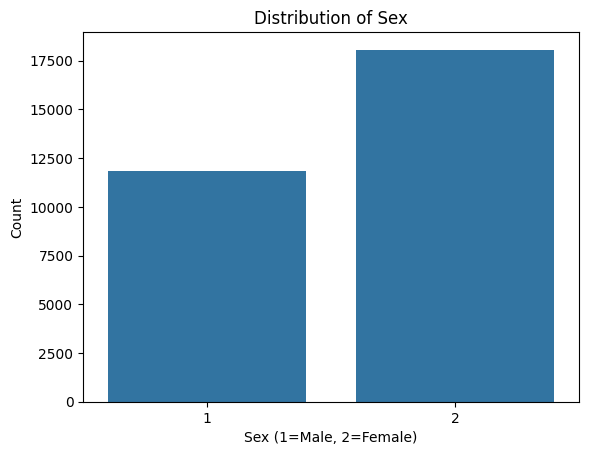

In [12]:
# 5. Examine the distribution of the variables for each class of the target variable

# SEX Distribution
sns.countplot(x="SEX", data=df)
plt.title("Distribution of Sex")
plt.xlabel("Sex (1=Male, 2=Female)")
plt.ylabel("Count")

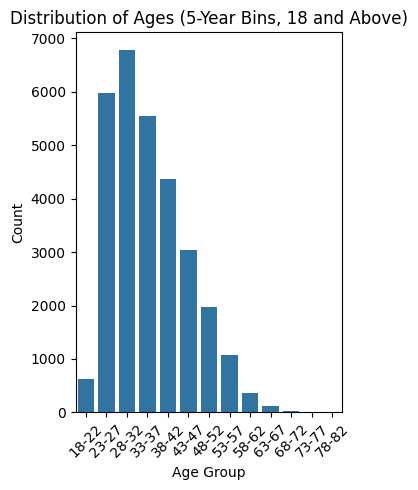

In [13]:
# AGE Distribution with 5-Year Bins (18 and Above)
# Filter out ages below 18
df_filtered = df[df["AGE"] >= 18].copy()

# Create 5-year bins starting from 18
bins = range(18, df_filtered["AGE"].max() + 5, 5)
labels = [f"{i}-{i+4}" for i in bins[:-1]]

# Create a new column for binned ages
df_filtered["AGE_BIN"] = pd.cut(
    df_filtered["AGE"], bins=bins, labels=labels, right=False
)

# Plot the binned data
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 3)
sns.countplot(x="AGE_BIN", data=df_filtered, order=labels)
plt.title("Distribution of Ages (5-Year Bins, 18 and Above)")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
df["EDUCATION"].value_counts()

EDUCATION
2    14024
1    10581
3     4873
5      280
4      123
6       51
Name: count, dtype: int64

Text(0, 0.5, 'Count')

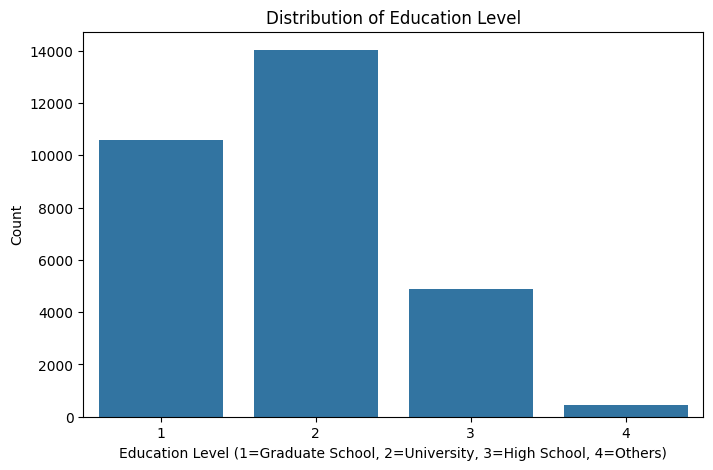

In [15]:
# EDUCATION Distribution
plt.figure(figsize=(8, 5))
df["EDUCATION"] = df["EDUCATION"].replace({4: 4, 5: 4, 6: 4})
sns.countplot(x="EDUCATION", data=df)
plt.title("Distribution of Education Level")
plt.xlabel("Education Level (1=Graduate School, 2=University, 3=High School, 4=Others)")
plt.ylabel("Count")

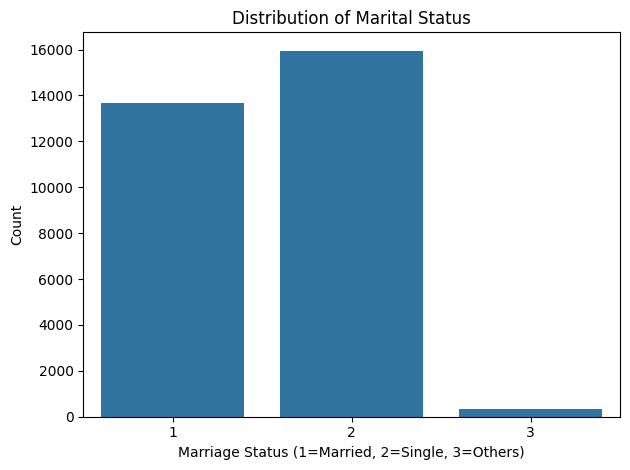

In [16]:
# MARRIAGE Distribution
sns.countplot(x="MARRIAGE", data=df)
plt.title("Distribution of Marital Status")
plt.xlabel("Marriage Status (1=Married, 2=Single, 3=Others)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

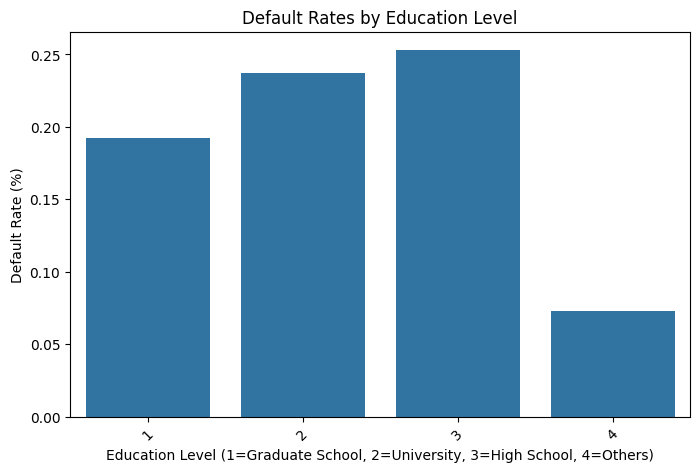

In [17]:
# Default Rate Analysis: Grouping by Education and checking default rates
default_rate = df.groupby("EDUCATION")["DEFAULT_STATUS"].mean().reset_index()
default_rate["TARGET"] = default_rate["DEFAULT_STATUS"] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x="EDUCATION", y="DEFAULT_STATUS", data=default_rate)
plt.title("Default Rates by Education Level")
plt.xlabel("Education Level (1=Graduate School, 2=University, 3=High School, 4=Others)")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.show()

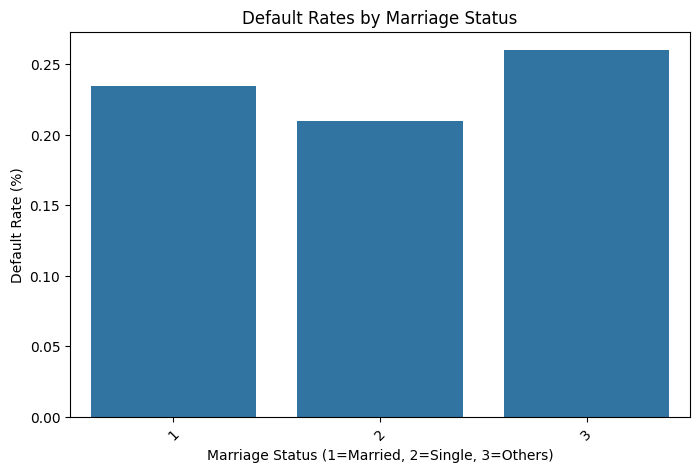

In [18]:
# Default Rate Analysis: Grouping by marriage status and checking default rates
default_rate = df.groupby("MARRIAGE")["DEFAULT_STATUS"].mean().reset_index()
default_rate["DEFAULT_STATS"] = default_rate["DEFAULT_STATUS"] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x="MARRIAGE", y="DEFAULT_STATUS", data=default_rate)
plt.title("Default Rates by Marriage Status")
plt.xlabel("Marriage Status (1=Married, 2=Single, 3=Others)")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.show()

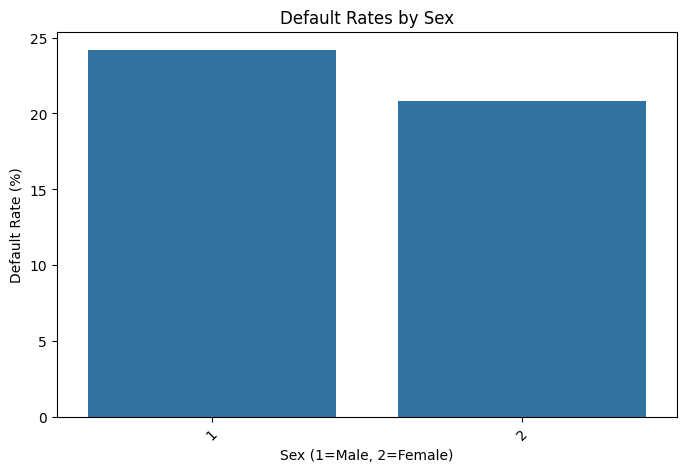

In [19]:
# Default Rate Analysis: Grouping by sex and checking default rates
default_rate = df.groupby("SEX")["DEFAULT_STATUS"].mean().reset_index()
default_rate["DEFAULT_STATUS"] = default_rate["DEFAULT_STATUS"] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x="SEX", y="DEFAULT_STATUS", data=default_rate)
plt.title("Default Rates by Sex")
plt.xlabel("Sex (1=Male, 2=Female)")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.show()

/var/folders/5m/q3t_7tx11l750b5hqf72gt3r0000gn/T/ipykernel_47160/3991432629.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["SEX", "AGE_BIN"])["DEFAULT_STATUS"].mean().reset_index()


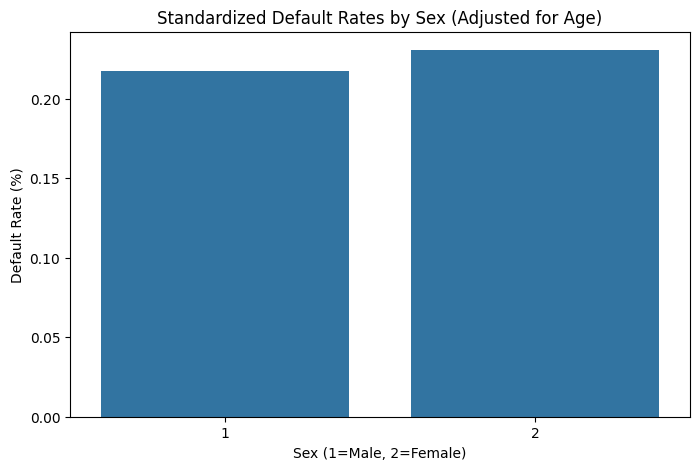

In [20]:
# Default Rate Analysis: Grouping by sex and checking default rates (standardized)
# Create 10-year age bins
bins = range(18, df["AGE"].max() + 10, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df["AGE_BIN"] = pd.cut(df["AGE"], bins=bins, labels=labels, right=False)

# Compute default rate by sex *and* age bin
grouped = df.groupby(["SEX", "AGE_BIN"])["DEFAULT_STATUS"].mean().reset_index()

# Compute standardized default rate (average over all age bins equally)
standardized = grouped.groupby("SEX")["DEFAULT_STATUS"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="SEX", y="DEFAULT_STATUS", data=standardized)
plt.title("Standardized Default Rates by Sex (Adjusted for Age)")
plt.xlabel("Sex (1=Male, 2=Female)")
plt.ylabel("Default Rate (%)")
plt.show()

/var/folders/5m/q3t_7tx11l750b5hqf72gt3r0000gn/T/ipykernel_47160/75735734.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby("AGE_BIN")["DEFAULT_STATUS"].mean().reset_index()


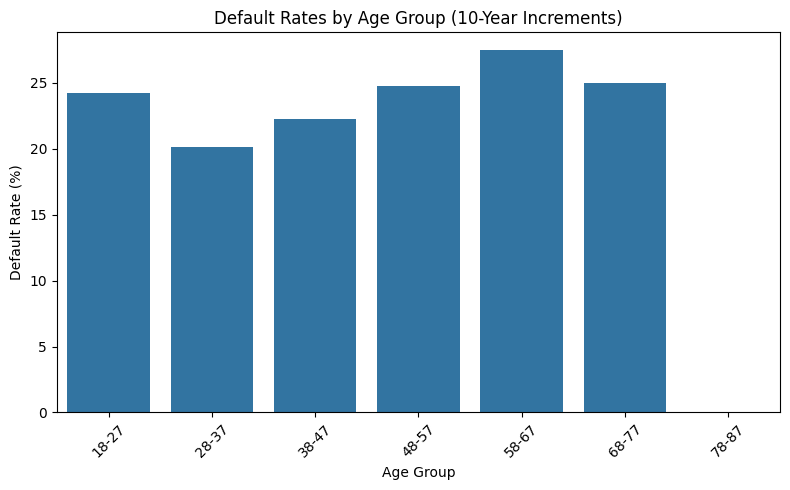

In [21]:
# Default Rate Analysis: Grouping by ages and checking default rates
# Create 10-year age bins (e.g., 18–27, 28–37, ...)
bins = range(18, df["AGE"].max() + 10, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Assign each AGE to a bin
df["AGE_BIN"] = pd.cut(df["AGE"], bins=bins, labels=labels, right=False)

# Compute default rates by age bin
default_rate = df.groupby("AGE_BIN")["DEFAULT_STATUS"].mean().reset_index()
default_rate["DEFAULT_STATUS"] = (
    default_rate["DEFAULT_STATUS"] * 100
)  # Convert to percentage

# Plot default rates by age group
plt.figure(figsize=(8, 5))
sns.barplot(x="AGE_BIN", y="DEFAULT_STATUS", data=default_rate, order=labels)
plt.title("Default Rates by Age Group (10-Year Increments)")
plt.xlabel("Age Group")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

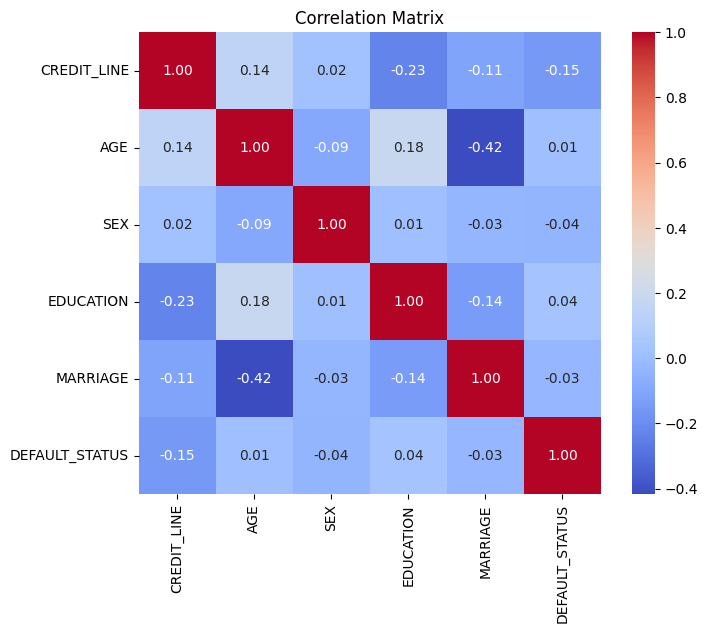

In [22]:
# Correlation Analysis: Correlation Matrix
corr = df[
    ["CREDIT_LINE", "AGE", "SEX", "EDUCATION", "MARRIAGE", "DEFAULT_STATUS"]
].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

The correlation matrix above illustrates the pairwise relationships between key variables, including CREDIT_LINE, AGE, SEX, EDUCATION, MARRIAGE, and the target variable (TARGET). Overall, the correlations are relatively weak, indicating that no single feature is strongly linearly related to another or to the target variable.

- CREDIT_LINE shows a slight negative correlation with TARGET (-0.15), suggesting that individuals with higher credit limits are marginally less likely to default. It also has a weak negative relationship with EDUCATION (-0.22), implying that higher education levels may be associated with higher credit limits.

- AGE has near-zero correlation with TARGET (0.01), meaning age alone is not strongly linearly related to default. However, it shows a mild positive correlation with EDUCATION (0.18) and a moderate negative correlation with MARRIAGE (-0.41), indicating that older individuals are more likely to be married and slightly more educated.

- SEX, EDUCATION, and MARRIAGE all have very weak correlations (|r| < 0.1) with TARGET, suggesting that while they may show significance in categorical tests (like the Chi-square test), their relationships are non-linear or categorical rather than continuous linear.

In [23]:
# List of categorical variables to test
categorical_vars = ["SEX", "EDUCATION", "MARRIAGE", "AGE_BIN"]

results = []

for var in categorical_vars:
    # Create contingency table
    contingency_table = pd.crosstab(df[var], df["DEFAULT_STATUS"])

    # Run Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store results
    results.append(
        {
            "Variable": var,
            "Chi2": chi2,
            "p-value": p,
            "Degrees of Freedom": dof,
            "Significant (α=0.05)": "Yes" if p < 0.05 else "No",
        }
    )

# Convert results to DataFrame
chi2_results = pd.DataFrame(results)
print("Chi-Square Test Results:\n")
print(chi2_results)

Chi-Square Test Results:

    Variable        Chi2       p-value  Degrees of Freedom  \
0        SEX   47.321241  6.025571e-12                   1   
1  EDUCATION  158.768939  3.379058e-34                   3   
2   MARRIAGE   30.272674  2.669146e-07                   2   
3    AGE_BIN   65.432239  3.520439e-12                   6   

  Significant (α=0.05)  
0                  Yes  
1                  Yes  
2                  Yes  
3                  Yes  


The Chi-Square test of independence was conducted to examine the relationship between several categorical variables—SEX, EDUCATION, MARRIAGE, and AGE_BIN—and the target variable (default status). The results indicated that all four variables showed statistically significant associations with default behavior at the 5% significance level. Specifically, SEX (χ² = 47.71, p < 0.001), EDUCATION (χ² = 163.22, p < 0.001), MARRIAGE (χ² = 35.66, p < 0.001), and AGE_BIN (χ² = 66.28, p < 0.001) were all found to significantly influence the likelihood of default. These findings suggest that default rates vary meaningfully across different demographic groups—by gender, education level, marital status, and age bracket. However, while these results confirm that associations exist, the Chi-Square test does not indicate the direction or strength of these relationships, nor does it imply causation. Further analysis, such as calculating effect sizes (e.g., Cramér’s V) or running multivariate logistic regression, is recommended to better understand the magnitude and independent impact of each variable on default risk.

In [ ]:
df.groupby(by="DEFAULT_STATUS").agg({"CREDIT_LINE": ["count", "min", "mean", "max"]})

/var/folders/5m/q3t_7tx11l750b5hqf72gt3r0000gn/T/ipykernel_47160/581112610.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(by="DEFAULT_STATUS").agg({'CREDIT_LINE':['count', 'min', 'mean', 'max']})


CREDIT_LINE                                   
                     count      min           mean        max
DEFAULT_STATUS                                               
0                    23301  10000.0  178168.833956  1000000.0
1                     6631  10000.0  130115.771377   740000.0

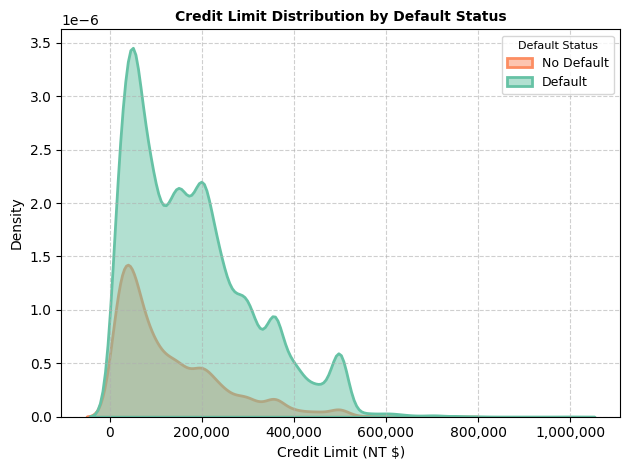

In [ ]:
import matplotlib.ticker as mtick

sns.set_palette("Set2")

sns.kdeplot(
    data=df, x="CREDIT_LINE", hue="DEFAULT_STATUS", fill=True, alpha=0.5, linewidth=2
)

# Title and axis labels with larger fonts
plt.title("Credit Limit Distribution by Default Status", fontsize=10, weight="bold")
plt.xlabel("Credit Limit (NT $)", fontsize=10)
plt.ylabel("Density", fontsize=10)

# Format x-axis with commas for readability
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Add grid lines
plt.grid(visible=True, linestyle="--", alpha=0.6)

# Legend with correct labels and title, better placement
plt.legend(
    title="Default Status",
    labels=["No Default", "Default"],
    loc="upper right",
    fontsize=9,
    title_fontsize=8,
)

plt.tight_layout()
plt.show()